# Object-Oriented Programming for Instrument Control

You can certainly use the general pyvisa API for communicating with your devices. However, you quickly end up in a situation where you have lots of different VISA calls and even if you put them in functions you end up with a lot of functions. This is not really sustainable if you want to reuse your instrument control. So let us look at how to make a reusable library for these instruments and how to use them together. 

For this section we will use object-oriented programming, which is ideal for writing controls for lab instruments.

## What is Object-Oriented Programming

from wikipedia:
> Object-oriented programming (OOP) is a programming paradigm based on the concept of "objects", which may contain data, in the form of fields, often known as attributes; and code, in the form of procedures, often known as methods. A feature of objects is that an object's procedures can access and often modify the data fields of the object with which they are associated (objects have a notion of "this" or "self"). In OOP, computer programs are designed by making them out of objects that interact with one another

In other words OOP is about creating object with certain characteristics and methods that can be used to access and control the behaviour of these objects. This also explains why it lends itself to instrument-control, the instruments are actually "real" objects that we are controlling.

Python is very well suited for OOP, because while it can be used for programming in many different ways, it was designed with OOP in mind and many concepts in Python are based on OOP.

## Learning Outcomes

* basic understanding of object-oriented programming
    * basic inheritance
* how to build lab instruments using object-oriented programming
* how to put several instruments together 


### Things we don't cover

Some of the following concepts make OOP very powerful. We will not cover them today, but we highly recommend you read up on them!

* metaprogramming
* duck-typing

**Important** While we will be using jupyter notebooks for writing the object here, generally you do not want to have your instrument control libraries in a notebook. Notebooks are great for initial experimentation, analysis and debugging, but you can not easily include (or import) the code from your notebook into other programs. Instead of copy and pasting your instruments from notebook to notebook, put them into a separate Python file that you can then import like any other Python module. 

## An Tektronix DPO scope object

In this section we will write an object to represent a Tektronix DPO70000 series scope. 

Along the way we will explain some of the OOP concepts in connection to Python. Note that we will only write an interface to a selection of the scope commands (the API of the scope is extremely large).

We start with a generic instrument object.

In [2]:
class LabInstrument(object): # Note classes are by convention written in CamelCase
    def __init__(self, visa_instrument):
        """
        Initialise a Tektronix DPO scope
        
        Parameters
        ----------
        
        visa_instrument : visa_object
            the visa resource for the instrument
        """
        self.instrument = visa_instrument

So what is happing in the above?

The `class` command creates an object class (the `(object)` indicates it is a subclass of the object class). This is basically the "blueprint" for a type of object. For example we could have the class of humans, which could possibly have subclasses women, men, children, adults, which all have different characteristics. It is possible that objects are members of several classes. 

The `__init__` is a method. Methods are functions that belong to an object. The first parameter to a method is (almost) always the `self` parameter, which is the object this function belongs to. The `__init__` method is one of several *special* methods, it gets called when we first initialise an object. 

Inside the `__init__` method we add three attributes to the object

Let's create the object:

In [6]:
import pyvisa as visa
import numpy as np
rm = visa.ResourceManager()
scope_inst = rm.open_resource("TCPIP0::192.168.1.195::INSTR")
dpo = LabInstrument(scope_inst)
print(dpo.instrument.query("*IDN?"))

TEKTRONIX,DPO73304SX,B300034,CF:91.1CT FV:10.6.1 Build 20



So far the instrument does not do anything so let us add some functionality to the instrument

In [4]:
class LabInstrument(object):
    def __init__(self, visa_instrument):
        """
        Initialise a Tektronix DPO scope
        
        Parameters
        ----------
        
        visa_instrument : visa_object
            the visa resource for the instrument
        """
        self.instrument = visa_instrument
    
    def idn(self):
        """
        Return instrument ID
        """
        return self.instrument.query("*IDN?")
    

In [7]:
dpo = LabInstrument(scope_inst)
print(dpo.idn())

TEKTRONIX,DPO73304SX,B300034,CF:91.1CT FV:10.6.1 Build 20



Here we see how to use the property decorator to convert a method into an attribute (in this case a read-only attribute)

In [9]:
class LabInstrument(object):
    def __init__(self, visa_instrument):
        """
        Initialise a Tektronix DPO scope
        
        Parameters
        ----------
        
        visa_instrument : visa_object
            the visa resource for the instrument
        """
        self.instrument = visa_instrument
    
    @property #we talk about decorators later
    def idn(self):
        """
        Return instrument ID
        """
        return self.instrument.query("*IDN?")
    

In [10]:
dpo = LabInstrument(scope_inst)
print(dpo.idn)

TEKTRONIX,DPO73304SX,B300034,CF:91.1CT FV:10.6.1 Build 20



We really don't want to talk to the instrument everytime we want to get the idea. Let's implement a poor man's cache.

In [11]:
class LabInstrument(object):
    def __init__(self, visa_instrument):
        """
        Initialise a Tektronix DPO scope
        
        Parameters
        ----------
        
        visa_instrument : visa_object
            the visa resource for the instrument
        """
        self.instrument = visa_instrument
    
    @property
    def idn(self):
        """
        Return instrument ID
        """ 
        try: #poor man's cache
            self._idn
        except AttributeError:
            self._idn = self.instrument.query("*IDN?") # the leading _ indicates private attributes
            return self._idn
    

In [12]:
if len(rm.list_opened_resources()) == 0:
    scope_inst = rm.open_resource("TCPIP0::192.168.1.195::INSTR")
dpo = LabInstrument(scope_inst)
print(dpo.idn)

TEKTRONIX,DPO73304SX,B300034,CF:91.1CT FV:10.6.1 Build 20



## Inheritance and more sophisticated classes

Let's say we want to build on this initial LabInstrument class to make some more sophisticated instruments, which however all have an idn property. We can use inheritance. 

We are now going to build the scope class

In [13]:
class DPO70000SX(LabInstrument): #here we indicate that we inherit from the LabInstrument class
    def __init__(self, visa_instrument):
        """
        Initialise a Tektronix DPO scope
        
        Parameters
        ----------
        
        visa_instrument : visa_object
            the visa resource for the instrument
        """
        super().__init__(visa_instrument) #super allows us to call the method of parent class
    
    @property # this property gives us the sampling rate of the scope
    def fs(self):
        return float(self.instrument.query("HOR:MODE:SAMPLERATE?"))

In [18]:
if len(rm.list_opened_resources()) == 0:
    scope_inst = rm.open_resource("TCPIP0::192.168.1.195::INSTR")
dpo = DPO70000SX(scope_inst)
print("IDN = {}".format(dpo.idn))
print("Sampling rate = {:f} GHz".format(dpo.fs/1e9))

IDN = TEKTRONIX,DPO73304SX,B300034,CF:91.1CT FV:10.6.1 Build 20

Sampling rate = 25.000000 GHz


### Read/write properties 

Unlike the IDN we likely want to change the sampling rate. For this we can make use of the `property.setter` decorator.

In [20]:
class DPO70000SX(LabInstrument):
    def __init__(self, visa_instrument):
        """
        Initialise a Tektronix DPO scope
        
        Parameters
        ----------
        
        visa_instrument : visa_object
            the visa resource for the instrument
        """
        self.instrument = visa_instrument
       
    @property
    def fs(self):
        return float(self.instrument.query("HOR:MODE:SAMPLERATE?"))
    
    @fs.setter
    def fs(self, fs):
        self.instrument.write("HOR:MODE:SAMPLERATE {:e}".format(fs))

In [24]:
if len(rm.list_opened_resources()) == 0:
    scope_inst = rm.open_resource("TCPIP0::192.168.1.195::INSTR")
dpo = DPO70000SX(scope_inst)
print("IDN = {}".format(dpo.idn))
print("Sampling rate = {:.1f} GHz".format(dpo.fs/1e9))
dpo.fs = dpo.fs/2
print("Sampling rate = {:.1f} GHz".format(dpo.fs/1e9))

IDN = TEKTRONIX,DPO73304SX,B300034,CF:91.1CT FV:10.6.1 Build 20

Sampling rate = 25.0 GHz
Sampling rate = 12.5 GHz


Finally, the advantage of OOP is that you can easily hide more complex calculations inside the methods, but they remain associated with the particular instrument

In [29]:
class DPO70000SX(LabInstrument):
    def __init__(self, visa_instrument):
        """
        Initialise a Tektronix DPO scope
        
        Parameters
        ----------
        
        visa_instrument : visa_object
            the visa resource for the instrument
        """
        self.instrument = visa_instrument
    
    @property
    def idn(self):
        """
        Return instrument ID
        """ 
        try: #poor man's cache
            self._idn
        except AttributeError:
            self._idn = self.instrument.query("*IDN?") # the leading _ indicates private attributes
            return self._idn
    
    @property
    def fs(self):
        return float(self.instrument.query("HOR:MODE:SAMPLERATE?"))
    
    @fs.setter
    def fs(self, fs):
        self.instrument.write("HOR:MODE:SAMPLERATE {:e}".format(fs))
                                            
    def get_data(self, channel_no, plot=False):
        self.instrument.write(":data:source ch{:d}".format(channel_no))
        self.instrument.write(":data:encdg fastest")
        self.instrument.write(":data:width 2")
        self.instrument.write(":data:start 1")
        self.instrument.write(":data:stop 1e10")

        # Read preamble
        pre = self.instrument.query(":wfmoutpre?").split(';')

        acq_format = pre[7].strip().upper()
        points = int(pre[6])
        point_size = int(pre[0])
        point_enc = pre[2].strip().upper()
        point_fmt = pre[3].strip().upper()
        byte_order = pre[4].strip().upper()
        x_unit = pre[8][1:-1]
        y_unit = pre[12][1:-1]
        x_increment = float(pre[9])
        x_origin = float(pre[10])
        x_reference = int(float(pre[11]))
        y_increment = float(pre[13])
        y_reference = int(float(pre[14]))
        y_origin = float(pre[15])
        
        raw = self.instrument.query_binary_values("CURVE?", datatype="b", container=np.array)
        x = (np.arange(raw.size) - x_reference) * x_increment + x_origin
        y = (raw - y_reference) * y_increment + y_origin
        if plot:
            import matplotlib.pylab as plt
            fig = plt.figure()
            plt.plot(x, y, lw=1)
            plt.xlabel("time [{}]".format(x_unit))
            plt.ylabel("Amplitude [{}]".format(y_unit))
            plt.show()
        return x,y


IDN = TEKTRONIX,DPO73304SX,B300034,CF:91.1CT FV:10.6.1 Build 20



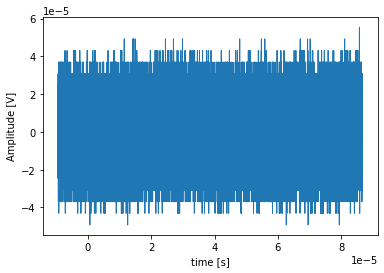

(array([-9.31199512e-06, -9.31191512e-06, -9.31183512e-06, ...,
         8.66877649e-05,  8.66878449e-05,  8.66879249e-05]),
 array([0.00000e+00, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 1.84689e-05]))

In [30]:
if len(rm.list_opened_resources()) == 0:
    scope_inst = rm.open_resource("TCPIP0::192.168.1.195::INSTR")
dpo = DPO70000SX(scope_inst)
print("IDN = {}".format(dpo.idn))
dpo.get_data(1, plot=True)

In [27]:
rm.list_opened_resources()[0].close()

IndexError: list index out of range